In [ ]:
# default_exp model.cvae
#default_cls_lvl 2

In [ ]:
# export
from snkrfinder.imports import *
from snkrfinder.core import *
from snkrfinder.data.munge import *
from snkrfinder.model.core import *
#from snkrfinder.model.transfer import *

from fastai.test_utils import show_install, synth_learner, nvidia_smi, nvidia_mem

In [ ]:
#hide
from nbdev.showdoc import *

# first snkrfinder.model.cvae



## OVERVIEW: cvae module - convolutional variational auto encoder

preamble: This is a project initiated while an Insight Data Science fellow.  It grew out of my interest in making data driven tools in the fashion/retail space I had most recently been working.   The original over-scoped idea was to make a shoe desighn tool which could quickly develop some initial sneakers based on choosing some examples, and some text descriptors.  Designs are constrained by the "latent space" defined (discovered?) by a database of shoe images.  However, given the 3 week sprint allowed for development, I pared the tool down to a simple "aesthetic" recommender for sneakers, using the same idea of utilizing an embedding space defined by the database fo shoe images.



### A: Sneaker Image Autoencoder in fastai v2
    - vanilla linear encoder / decoder
    - convolutional (resnet) encoder / decoder

### B: Sneaker Image Variational Autoencoder in fastai v2
    
    - Encoders:  
        - vanilla convolutional bottleneck
        - pretrained encoders
        
    - VAE "bottleneck":  linear encoding of latent space + "reparameterazation trick" linear decoding
    
    - beta-VAE: by increasing the relative strenght of error signal of the KLD through a beta variational parameter we can get better formed latent spaces which are somewhat "disentangled". That is have some semantic or meaningful structure in the representation. 
    
    - Decoders / generators
        - using convolutional upsampling blocks rather than convTransposes.

    - non-variational autoencoder
    
    - MME variational autoencoder
        - The KLD has some problems and "over-regularizes" or simply isn't strong enough compared to the MSE loss and tends to converge to a somewhat degenerate solution
        - MME regularization of the latent space has great advantage but at a computational expense

### C: ?? Sneaker Image Variational Autoencoder + GAN in fastai v2
    - GAN finetuning?
    - crappify general pattern


### TODO: model based data cleaning (widget module?)
1. throw out based on inspection of high loss
2. try mixed labels?  things that are >50% sneakers included???



In [ ]:
#hide
show_install()



```text
=== Software === 
python        : 3.8.2
fastai        : 2.2.7
fastcore      : 1.3.19
fastprogress  : 0.2.7
torch         : 1.7.1
nvidia driver : 460.39
torch cuda    : 11.0 / is available
torch cudnn   : 8005 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : GeForce RTX 2070 SUPER

=== Environment === 
platform      : Linux-5.8.0-7642-generic-x86_64-with-glibc2.10
distro        : #47~1614007149~20.10~82fb226-Ubuntu SMP Tue Feb 23 02:59:01 UTC 
conda env     : fastai
python        : /home/ergonyc/anaconda3/envs/fastai/bin/python
sys.path      : /home/ergonyc/Projects/Project2.0/snkrfinder/nbs
/home/ergonyc/anaconda3/envs/fastai/lib/python38.zip
/home/ergonyc/anaconda3/envs/fastai/lib/python3.8
/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/lib-dynload

/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/site-packages
/home/ergonyc/anaconda3/envs/fastai/lib/python3.8/site-packages/locket-0.2.1-py3.8.egg
/home/ergonyc/anaconda3/envs/fastai/lib/

In [ ]:
#hide
#nvidia_smi()


In [ ]:
#hide 
# fix our base directory
print(Path().cwd())
os.chdir(L_ROOT)
print(Path().cwd())

/home/ergonyc/Projects/Project2.0/snkrfinder/nbs
/home/ergonyc/Projects/Project2.0/snkrfinder


## Using  fastai V2: data pipelining
- Datablock API
- check that tfms are applied to input/target
- labeling func: `lambda o: o`

Load the saved merged database, and set the seeds.  And doublecheck our data is where we expect.

In [ ]:

df = pd.read_pickle(f"data/{COMBINED_DF}.pkl")
np.random.seed(3333)
torch.manual_seed(3333)


In [ ]:
#TODO:  fix the data layout... the links and paths are screwy
image_path = L_ROOT/"data"
#image_path = D_ROOT/DBS['zappos']
batch_size = 64

L([image_path/d for d in df.path])

(#11771) [Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8045616.9.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8045632.9.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8045650.3.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8045650.9.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8093302.3.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8093302.396.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8093302.4854.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/8093302.9.jpg'),Path('/home/ergonyc/Projects/Project2.0/snkrfinder/data/Shoes/Sneakers and Athletic Shoes/ALDO/80

In [ ]:
# export

def prep_df_for_datablocks(df):
    df = df[["path","train","test","validate","t_t_v"]].copy()
    # I could remove all the "test" rows... for now i'll choose an alternate strategy:
    # Drop all the "test" rows for now, and create an "is_valid" column...
    # should probably drop a ton of columns to jus tkeep the file paths...
    # just keep what we'll need below
    df.loc[:,'is_valid'] = df.test | df.validate
    return df



In [ ]:
df = prep_df_for_datablocks(df)

In [ ]:
#export

# some helper functions borrowed from validating the feature embedding
def df_get_x(r): 
    return image_path/r['path']

def df_get_y(r): 
    # we want to return a tuple so that we predict latent variables...
    return (df_get_x(r),None,None)

In [ ]:
#export
def get_ae_btfms():
    batch_tfms = Normalize.from_stats(*imagenet_stats)
    rand_tfms = aug_transforms(mult=1.0, 
               do_flip=True, 
               flip_vert=False, 
               max_rotate=3.0, 
               min_zoom=.95, 
               max_zoom=1.0, 
               max_lighting=0.1, 
               max_warp=0.023, 
               p_affine=0.66, 
               p_lighting=0.2, 
               xtra_tfms=None, 
               size=None, 
               mode='bilinear', 
               pad_mode='border', 
               align_corners=True, 
               batch=False, 
               min_scale=1.0)
    return rand_tfms+[batch_tfms]

def get_ae_no_aug():
    batch_tfms = Normalize.from_stats(*imagenet_stats)
    return [batch_tfms]

## Should we create an autoencoder "block"

Next we need our own version of ReadTabBatch that will return our inputs


### TODO:  create a VAE datablock class or dataloaders class to add to the repository


In [ ]:
#export

class LatentTuple(fastuple):
    "Basic type for tuple of tensor (vectors)"
    _show_args = dict(s=10, marker='.', c='r')
    @classmethod
    def create(cls, ts): 
        if isinstance(ts,tuple):
            mu,logvar = ts
        elif ts is None:
            mu,logvar = None,None
        else:
            mu = None
            logvar = None
            
        if mu is None: mu = torch.empty(0)
        elif not isinstance(mu, Tensor): Tensor(mu) 
        
        if logvar is None: logvar = torch.empty(0)
        elif not isinstance(logvar,Tensor): Tensor(logvar)
            
        return cls( (mu,logvar) ) 
        
    def show(self, ctx=None, **kwargs): 
        mu,logvar = self
        if not isinstance(mu, Tensor) or not isinstance(logvar,Tensor): return ctx

        title_str = f"mu-> {mu.mean():e}, {mu.std():e}  logvar->{logvar.mean():e}, {logvar.std():e}"
    
        if 'figsize' in kwargs: del kwargs['figsize']
        if 'title' in kwargs: kwargs['title']=title_str
        if ctx is None:
            _,axs = plt.subplots(1,2, figsize=(12,6))
            x=torch.linspace(0,1,mu[0].shape[0])
            axs[0].scatter(x, mu[:], **{**self._show_args, **kwargs})
            axs[1].scatter(x, logvar[:], **{**self._show_args, **kwargs})
            ctx = axs[1]
        
        ctx.scatter(mu[:], logvar[:], **{**self._show_args, **kwargs})
        return ctx
    
    

class TensorPoint(TensorBase):
    "Basic type for points in an image"
    _show_args = dict(s=10, marker='.', c='r')

    @classmethod
    def create(cls, t, img_size=None)->None:
        "Convert an array or a list of points `t` to a `Tensor`"
        return cls(tensor(t).view(-1, 2).float(), img_size=img_size)

    def show(self, ctx=None, **kwargs):
        if 'figsize' in kwargs: del kwargs['figsize']
        x = self.view(-1,2)
        ctx.scatter(x[:, 0], x[:, 1], **{**self._show_args, **kwargs})
        return ctx


class Tensor2Vect(TensorPoint): pass

class LatentsTensor(Tensor2Vect):
    "Basic type for latents as Tensor inheriting from TensorPoint (vectors)"
    @classmethod
    def create(cls, ts, img_size=IMG_SIZE): 
        "create IMG_SIZE attr to register plotting..."

        if isinstance(ts,tuple):
            mu,logvar = ts
        elif ts is None:
            mu,logvar = None,None
        else:
            mu = None
            logvar = None
        if mu is None: mu = torch.empty(0)
        elif not isinstance(mu, Tensor): Tensor(mu) 
        
        if logvar is None: logvar = torch.empty(0)
        elif not isinstance(logvar,Tensor): Tensor(logvar)
        
        t = torch.cat([mu,logvar],dim=-1) # in case its a batch?
                
        return cls(tensor(t).view(-1, 2).float(), img_size=img_size)

    
### TODO:  fixe the .show() method to make barcode style images appended to sneaker pic
#     def show(self, ctx=None, **kwargs):
#         if 'figsize' in kwargs: del kwargs['figsize']
#         x = self.view(-1,2)
#         ctx.scatter(x[:, 0], x[:, 1], **{**self._show_args, **kwargs})
#         return ctx
#         mu,logvar = self
#         if not isinstance(mu, Tensor) or not isinstance(logvar,Tensor): return ctx

#         title_str = f"mu-> {mu.mean():e}, {mu.std():e}  logvar->{logvar.mean():e}, {logvar.std():e}"
    
#         if 'figsize' in kwargs: del kwargs['figsize']
#         if 'title' in kwargs: kwargs['title']=title_str
#         if ctx is None:
#             _,axs = plt.subplots(1,2, figsize=(12,6))
#             x=torch.linspace(0,1,mu[0].shape[0])
#             axs[0].scatter(x, mu[:], **{**self._show_args, **kwargs})
#             axs[1].scatter(x, logvar[:], **{**self._show_args, **kwargs})
#             ctx = axs[1]
        
#         ctx.scatter(mu[:], logvar[:], **{**self._show_args, **kwargs})
#         return ctx


# TODO:  create Rank 1 tensor class with a show that either makes a bar-code to append to the image, or plots some latents kdes histograms

In [ ]:
#export 
# could we do a typedispatch to manage the transforms...?
# def VAETargetTupleBlock(): 
#     return TransformBlock(type_tfms=VAETargetTuple.create, batch_tfms=IntToFloatTensor)

def LatentTupleBlock(): 
    return TransformBlock(type_tfms=LatentTuple.create, batch_tfms=noop)


def LatentsTensorBlock(): 
    return TransformBlock(type_tfms=LatentsTensor.create, batch_tfms=noop)


def df_ae_x(r): 
    return image_path/r['path']


# need to make sure that we get the image whihc is "Identical" to the input.. how to test?
# lambda o: o
def df_ae_y(r): 
    # we want to return a tuple so that we predict latent variables...
    return df_get_x(r)


Don't forget to set  `n_inp=1`. Otherwise the default to make the  input to 1-len(blocks)

In [ ]:
# consider using FeatsResize and force all the randomness to the batch trnasforms.

block = DataBlock(blocks=(ImageBlock(cls=PILImage), ImageBlock(cls=PILImage), LatentsTensorBlock ),
              get_x=df_ae_x, 
              get_y=[df_ae_y, noop], #don't need to get the LatentTupleBlock, just create
              splitter=ColSplitter('is_valid'), 
              item_tfms= Resize(IMG_SIZE,method='pad', pad_mode='border'),
              batch_tfms = get_ae_btfms() ,
              n_inp = 1)
 

In [ ]:
dls = block.dataloaders(df, batch_size=batch_size)

In [ ]:
b = dls.one_batch()
explode_types(b)

{tuple: [fastai.torch_core.TensorImage,
  fastai.torch_core.TensorImage,
  __main__.LatentsTensor]}

In [ ]:
#export
# 

def get_ae_DataBlock(aug=True):
    "wrapper to get the standard ae datablock"
    mytfms = get_ae_btfms() if aug else get_ae_no_aug()
    block = DataBlock(blocks=(ImageBlock(cls=PILImage), ImageBlock(cls=PILImage), LatentsTensorBlock ),
              get_x=df_ae_x, 
              get_y=[df_ae_y, noop], #don't need to get the LatentsTensorBlock, just create
              splitter=ColSplitter('is_valid'), 
              item_tfms= Resize(IMG_SIZE,method='pad', pad_mode='border'),
              batch_tfms = mytfms,
              n_inp = 1)
 
    return block



In [ ]:
block = get_ae_DataBlock(aug=True)
#block.summary(df)

In [ ]:
dls = block.dataloaders(df, batch_size=batch_size)

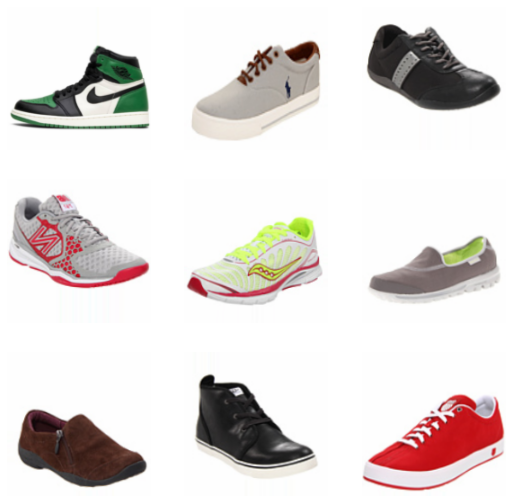

In [ ]:
dls.show_batch()

In [ ]:
#hide

# lets grab a batch to have it handy for testing
x,y,z = dls.one_batch()
x.shape, y.shape,z[0].shape



AttributeError: 'torch.return_types.min' object has no attribute 'shape'

In [ ]:



# extrema = torch.cat([torch.zeros((1,2,2,3)),torch.ones((1,2,2,3))],dim=0)


# extrema,Normalize.from_stats(*imagenet_stats)(extrema),*imagenet_stats





# dl = dls.train

# for o in enumerate(dl):
#     break

In [ ]:
# o[1][1].shape

## creating the VAE

Variational Auto-Encoder for fastai

I'm going to use a generic convolutional net as the basis of the encoder, and its reverse as the decoder. This is a proof of concept for using the _fastai_ framework, and will experiment with pre-trained resnet and MobileNet_v2 later. I'd like to use the MobileNet_v2 as a direct link ot the "SneakerFinder" tool which motivated this experiment. [see SneakerFinder]

A variational "module" will sit between the encoder and decoder as the "Bottleneck". The Bottleneck will map the resnet features into a latent space (e.g. ~100 dimensions) represented of standard normal variables.  The "reparameterization trick" will sample from this space and the "decoder" will generate images. 

Finally a simple "decoder" will sample from the variational latents space and be trained to reconstruct the images. 

The intention is the latent space can be used to generate novel sneaker images.



### constructing VAE with Module Class Layers

For several of the decoder and "sampler" layers I might want to turn off the nonlinearity to give us more reasonable "gaussian" outputs to the Variational layer and the generated image which will is compared with the ImageNetStats batch-normalized image.



> IMPORTANT VAE TIP!!!   Make sure NOT to use batch normalization and non-linearity in the linear layers of the VAE.  The normalization will affect the representation and the KLD constraints.

In [ ]:
#export

class VAELinear(Module):
    def __init__(self,in_features,latent_features):
        self.mu_linear = nn.Linear(in_features,latent_features)
        self.logvar_linear = nn.Linear(in_features,latent_features)

    def forward(self,h):
        #h = self.fc_in(h)
        return self.mu_linear(h), self.logvar_linear(h)

    
    
class VAELayer(Module):
    """
    The VAE : in_features to latent_features through 
        the "Variational" magic: "reparamaterization trick"
    """
    def __init__(self,in_features,latent_features):
        self.mu_logvar = VAELinear(in_features,latent_features)

    # 
    def reparam(self,mu,logvar):
        # should we pass through a deterministic code when not training?
        if False: return mu # self.training
    
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    
    def forward(self,h):
        mu,logvar = self.mu_logvar(h)
        #logvar = F.softplus(logvar)   # force logvar>0
        z = self.reparam(mu,logvar) # adds the noise by the reparam trick
        
        return z, mu, logvar
    
              
class VAEBottleneck(Module):
    """
    BOTTLENECK:  a fc/linear step down to hidden_dim before the latent_dim VAE
    """
    def __init__(self,input_dim,hiden_dim,latent_dim,bn=False,drop_p=0.0,act=nn.ReLU()):
        self.bn = nn.Sequential(LinBnDrop(input_dim,hidden_dim,bn=bn),
                        VAELayer(in_features=hidden_dim, out_features=latent_dim))

    def forward(self,h):
        # maybe assert that the shape is bs,encoder_features?
        z,mu,logvar = self.bn(h)
        return z, mu, logvar

In [ ]:
#export
class UpsampleBlock(Module):
    def __init__(self, up_in_c:int, final_div:bool=True, blur:bool=False, leaky:float=None, **kwargs):
        """
        up_in_c :  "Upsample input channel"
        """
        self.shuf = PixelShuffle_ICNR(up_in_c, up_in_c//2, blur=blur, **kwargs)
        ni = up_in_c//2
        nf = ni if final_div else ni//2
        self.conv1 = ConvLayer(ni, nf, **kwargs) # since we'llapply it by hand...
        self.conv2 = ConvLayer(nf, nf, **kwargs)

    def forward(self, up_in:Tensor) -> Tensor:
        up_out = self.shuf(up_in)
        return self.conv2(self.conv1(up_out))
    
    #     def shuff(self,up_in:Tensor) -> Tensor:
    #         up_out = self.shuf(up_in)
    #         cat_x = self.relu(up_out)
    #         return cat_x


In [ ]:
#doc(ConvLayer)

### simple VAE class from VAE layer class components

once we have this we can do three things:

    1. develop proper VAE loss functions (including KL Divergence constraint on latent variables)
    2. create callbacks (and custom learner?) for training
    3. extend to a beta-variational framework with aims at creating "disentangled" latent dimensions
    

In [ ]:
#export

class AEEncoder(Module):
    def __init__(self,arch_body,enc_dim=512, hidden_dim=2048, im_size=IMG_SIZE):
        """
        arch_body   list of layers (e.g. arch.children()[:cut])    
        enc_dim,
        hidden_dim
        """
        #store_attr('enc_dim,latent_dim, hidden_dim,im_size')

        BASE = im_size//2**5
 
        # encoder
        self.in_dim = enc_dim * BASE**2  # 2**(3*3) * (im_size//32)**2 #(output of resneet) #12800
        
        self.encoder = nn.Sequential(*arch_body,
                                 Flatten(),
                                 LinBnDrop(self.in_dim,hidden_dim,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)
                                )

    def forward(self, x):
        return self.encoder(x)

      
        
class AEDecoder(Module):
    def __init__(self, hidden_dim=2048, latent_dim=128, im_size=IMG_SIZE,out_range=[-3,3]):
        """
        
        latent_dim,
        hidden_dim,
        im_size,
        out_range
        """
        BASE = im_size//2**5
        #store_attr('enc_dim,latent_dim, hidden_dim,im_size')

        

        #decoder
        n_blocks = 5        
        nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
        nfs.reverse()
        n = len(nfs)
        
        modules =  [UpsampleBlock(nfs[i]) for i in range(n - 2)]        
        self.decoder = nn.Sequential( LinBnDrop(latent_dim,hidden_dim,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                     LinBnDrop(hidden_dim,im_size*n_blocks*n_blocks,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                      ResizeBatch(im_size,n_blocks,n_blocks),
                                      *modules,
                                      ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None, #act_cls=nn.Sigmoid) )
                                                act_cls=partial(SigmoidRange, *out_range)))
        


    def forward(self, z):    
        z = self.decoder(z)
        return z
    

Its convenient to avoid the class wrappers to simplify the param splitting for freezing the pre-trained arcitecture.  
We could enumerate the class layers and return sequential, but simply making some functions to put the layers togeter is better.

In [ ]:
# export
    
    
def build_AE_encoder(arch_body,enc_dim=512, hidden_dim=2048, im_size=IMG_SIZE):
        """
        arch_body   list of layers (e.g. arch.children()[:cut])    
        enc_dim,
        hidden_dim
        """
        BASE = im_size//2**5
        # encoder
        in_dim = enc_dim * BASE**2  # 2**(3*3) * (im_size//32)**2 #(output of resneet) #12800
        
        encoder = nn.Sequential(*arch_body,
                                 Flatten(),
                                 LinBnDrop(in_dim,hidden_dim,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)
                                )

        return encoder
        
def build_AE_decoder(hidden_dim=2048, latent_dim=128, im_size=IMG_SIZE,out_range=[-3,3]):
        BASE = im_size//2**5
        #store_attr('enc_dim,latent_dim, hidden_dim,im_size')

        

        #decoder
        n_blocks = 5        
        nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
        nfs.reverse()
        n = len(nfs)
        
        modules =  [UpsampleBlock(nfs[i]) for i in range(n - 2)]        
        decoder = nn.Sequential( LinBnDrop(latent_dim,hidden_dim,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                     LinBnDrop(hidden_dim,im_size*n_blocks*n_blocks,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                      ResizeBatch(im_size,n_blocks,n_blocks),
                                      *modules,
                                      ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None, #act_cls=nn.Sigmoid) )
                                                act_cls=partial(SigmoidRange, *out_range)))
        
        return decoder

    

class VAEtrans(Module):
    def __init__(self,enc_arch,enc_dim=512,hidden_dim=2048, latent_dim=128, im_size=IMG_SIZE,out_range=[-3,3]):
       
        """
        inputs:  
            arch, cut,pretrained
            enc_dim
            latent_dim
            hidden_dim
            
        """
        store_attr('enc_dim, hidden_dim,latent_dim,im_size')

        # encoder
        #  arch,cut = xresnet18(pretrained=True),-4
        #  enc_arch = list(arch.children())[:cut]
        
        self.encoder = build_AE_encoder(enc_arch,enc_dim=enc_dim, hidden_dim=hidden_dim, im_size=im_size)


        # VAE Bottleneck
        self.bn = VAELayer(self.hidden_dim,self.latent_dim)     

        #decoder
        self.decoder = build_AE_decoder(hidden_dim=hidden_dim, latent_dim=latent_dim, im_size=im_size,out_range=out_range)



    def decode(self, z):    
        z = self.decoder(z)
        return z
    
    def reparam(self, h):
        return self.bn(h)

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.reparam(h)
        return z, mu, logvar

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        x_hat = self.decode(z)
        latents = torch.stack([mu,logvar],dim=-1)
        return x_hat, latents # assume dims are [batch,latent_dim,concat_dim]
    
 

In [ ]:

# arch,cut = xresnet18(pretrained=True),-4
# enc_arch = list(arch.children())[:cut]

# rnet_vae = VAEtrans(enc_arch,enc_dim=512, hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=[-3,3])
    
    

In [ ]:
# arch,cut = torchvision.models.mobilenet_v2(pretrained=True),-1
# enc_arch = list(arch.children())[:cut]

# mnet_vae = VAEtrans(enc_arch,enc_dim=512,  hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=[-3,3])
    



      

In [ ]:
#hide

# this is the pre-  refactored working version
class VAE_rnet(Module):
    def __init__(self,enc_dim=512, hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=[-3,3]):
        #  drop_p=0.0 default turns off dropout
        
        self.im_size=im_size
        BASE = im_size//2**5
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        # encoder
        arch,cut = xresnet18(pretrained=True),-4
        self.in_dim = enc_dim * BASE**2  # 2**(3*3) * (im_size//32)**2 #(output of resneet) #12800
        
        self.encoder = nn.Sequential(*list(arch.children())[:cut],
                                 Flatten(),
                                 LinBnDrop(self.in_dim,self.hidden_dim,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)
                                )



        # VAE Bottleneck
        self.bn = VAELayer(self.hidden_dim,self.latent_dim)     

        #decoder
        n_blocks = 5        
        nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
        nfs.reverse()
        n = len(nfs)
        
        modules =  [UpsampleBlock(nfs[i]) for i in range(n - 2)]        
        self.decoder = nn.Sequential( LinBnDrop(latent_dim,self.hidden_dim,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                     LinBnDrop(hidden_dim,im_size*n_blocks*n_blocks,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                      ResizeBatch(im_size,n_blocks,n_blocks),
                                      *modules,
                                      ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None, #act_cls=nn.Sigmoid) )
                                                act_cls=partial(SigmoidRange, *out_range)))
        


    def decode(self, z):    
        z = self.decoder(z)
        return z
    
    def reparam(self, h):
        return self.bn(h)

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.reparam(h)
        return z, mu, logvar

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        x_hat = self.decode(z)
        latents = torch.stack([mu,logvar],dim=-1)
        return x_hat, latents # assume dims are [batch,latent_dim,concat_dim]
    
    

In [ ]:
# resnet_vae = VAE_rnet(enc_dim=512)
# resnet_vae

In [ ]:
# x,y,z = dls.one_batch()
# x.shape,y.shape,z.shape


# x[0].squeeze()-y[0].squeeze()

# x_hat,latents = resnet_vae.cuda()(x)
# x_hat.shape,latents.shape

# mu, logvar = latents.split(1,dim=2)

# KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(),1)

# mu.shape,logvar.shape,KLD.shape,x_hat.shape,KLD.mean()

# mse = MSELossFlat(reduction='sum')

# er=mse(x,x_hat)
# er,mu.shape

Sweet, we've verified the arcitecture works, but we need to train it with a loss that constrains the variational layers with the KL Divergence.  Otherwise the simple MSE will diverge.  

## VAE Loss functions classes

We have acouple examples to follow:  

    1. TabularData Vae (fastai v2 patterning) (@EtienneT)

~~pure PyTorch Vae which is directly related to our image dataset (@AntixK)~~

In [ ]:
#export

# called `after_batch`
class BVAELoss(Module):
    """
    Measures how well we have created the original image, 
    plus the KL Divergence with the unit normal distribution
    """
    def __init__(self, b_weight=1.):
        mse = MSELossFlat(reduction='sum')
        store_attr('mse,b_weight')
        
    def forward(self, preds, *target):
        """
        pred =(x_hat,KLD,kl_weight) #mu,log_var, kl_weight)
        target is x (original) 
        """
        
        # this handles the annealed kl_weight and passing the mu,logvar around we added...
        if(len(preds) == 3):
            x_hat, latents, kl_weight = preds
        else: #if len(preds) == 2:  # we should never get here... unless we delete teh callback
            x_hat, latents = preds
            
            kl_weight = x_hat[0].new(1)
            kl_weight[0] = 1.0
        
        #mu,logvar = latents[:,:,0],latents[:,:,1]
        mu, logvar = latents.split(1,dim=2)

        #note: both mse and KLD are summing errors over batches, and pixels or latents 
        total = self.mse(x_hat, target[0]) 
        
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        KLD = self.b_weight*KLD.sum()
                
        return (total + KLD*kl_weight)

    

The fastai `Learner` class does the training loop.  It took me a little digging into the code to figure out how Metrics are called since its not really stated anywhere in the documentation (_Note: create PR for fastai for extra documentation on `Metrics` logic_).  By default one of the key `Callbacks` is the `Recorder`.  It prints out the training summary at each epoch (via `ProgressCallBack`) and collects all the `Metrics`. Which by default only loss is a `train_met` and others are `valid_met`.
The `Recorder` resets (maps `reset()` to all mets) the metrics `before_train` and `before_valid`. The `Recorder` maps `accumulate()` to the metrics on `after_batch`.  Finally

In [ ]:
#export

# test: if i call them preds instead of vals might the Metric base class reset automatically?
class MyMetric(Metric):
    "for simple average over batch quantities"
    def reset(self):
        "Clear all targs and preds"
        self.vals = []
    @property
    def value(self):
        return np.array(self.vals).mean()

class MSEMetric(MyMetric):
    def __init__(self): 
        self.vals= []
    def accumulate(self, learn):
        x_hat = learn.pred[0]
        x_targs = learn.y[0]
        self.vals.append(  to_detach( F.mse_loss(x_hat, x_targs, reduction='sum') ))
    
class RawKLDMetric(MyMetric):
    def __init__(self): 
        self.vals = []
    def accumulate(self, learn):
        latents = learn.pred[1]                
        mu, logvar = latents.split(1,dim=2)
        KLD =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        self.vals.append(to_detach(KLD)) 
    
class BWeightedKLDMetric(MyMetric):
    def __init__(self,b_weight=1.): 
        self.vals = []
        self.b_weight = b_weight
    def accumulate(self, learn):
        latents = to_detach(learn.pred[1])
        mu, logvar = latents.split(1,dim=2)
        # _,mu,logvar = to_detach(learn.pred)
        KLD = self.b_weight * -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        self.vals.append( KLD ) 
    
class MuMetric(MyMetric):
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        latents = to_detach(learn.pred[1])
        mu, logvar = latents.split(1,dim=2)
        self.vals.append(mu.mean())

    
class MuSDMetric(MyMetric):
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        latents = to_detach(learn.pred[1])
        mu, logvar = latents.split(1,dim=2)
        self.vals.append(mu.std())

    
    
class StdMetric(MyMetric):
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        latents = to_detach(learn.pred[1])
        mu, logvar = latents.split(1,dim=2)
        self.vals.append(torch.exp(0.5 * logvar.mean())) 
        
        torch.exp(0.5 * logvar)
        
class StdSDMetric(MyMetric):
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        latents = to_detach(learn.pred[1])
        mu, logvar = latents.split(1,dim=2)
        self.vals.append(torch.exp(0.5 * logvar.std())) 


        
class KLWeightMetric(MyMetric):
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        #kl = learn.model.kl_weight
        kl = learn.opt.hypers[0]['kl_weight']
        #KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        self.vals.append(kl) 


AnnealedLossCallback will inject the latent mu and logvar and a kl_weight variable into our loss.  The `mu` and `logvar` will be used to compute the KLD. The kl_weight is a scheduled weighting for the KLD. You can see the schedule graph of the parameter. At the beginning it will be 0, thus the KLD part of the loss will get ignored. So during 10% of training, we will fit a normal auto-encoder. Then gradually for 30% of trainning, increase kl_weight to 1 and then remain there for the remaining training time so that the auto encoder now becomes full variational. The way this callback is done, the loss will receive this parameter, but not the model.

In [ ]:
#export
        
class AnnealedLossCallback(Callback):
    def after_pred(self):
        kl = self.learn.pred[0].new(1)
        kl[0] = self.opt.hypers[0]['kl_weight']
        self.learn.pred = self.learn.pred + (kl,)
    def after_batch(self):
        pred, latents, _ = self.learn.pred
        self.learn.pred = (pred,latents)
        
        
        
def default_KL_anneal_in():
    return combine_scheds([.1, .7, .2], [SchedNo(0,0),SchedCos(0,1), SchedNo(1,1)])

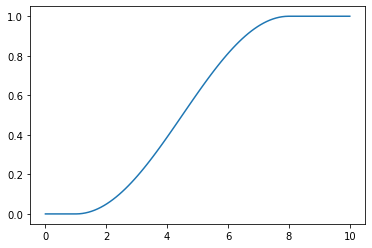

In [ ]:
# lets start with ~10 epochs of no KL regularizaiton, and ramp through the next 5
n_epochs = 10
f_init = combine_scheds([.1, .7, .2], [SchedNo(0,0),SchedCos(0,1), SchedNo(1,1)])
# f = combine_scheds([.8, .2], [SchedCos(0,0), SchedCos(0,.5)])
p = torch.linspace(0.,1.,100)
pp = torch.linspace(0.,1.*n_epochs,100)

plt.plot(pp,[f_init(o) for o in p])

We'll make an config dictionary for us to use as a list of all hyper parameters. Also we avoid using early stopping because the AnnealedLossCallback will make the loss grow once the KL divergence weight kicks in.


In [ ]:
#export

# note that it is crucial that you don't freeze the batch norm layers... 
def bn_splitter(m):
    def _bn_splitter(l, g1, g2):
        if isinstance(l, nn.BatchNorm2d): g2 += l.parameters()
        elif hasattr(l, 'weight'): g1 += l.parameters()
        for ll in l.children(): _bn_splitter(ll, g1, g2)
        
    g1,g2 = [],[]
    _bn_splitter(m[0], g1, g2)
    
    g2 += m[1:].parameters()
    return g1,g2

def resnetVAE_split(m): 
    to_freeze, dont_freeze = bn_splitter(m.encoder)
    #return L(to_freeze, dont_freeze + params(m.bn)+params(m.dec[:2]), params(m.dec[2:]))
    return L(to_freeze, dont_freeze + params(m.bn)+params(m.decoder))
    #return L(fz, nofz + params(m.bn)+params(m.dec[:6]), params(m.dec[6:]))
    

    
def VAEtrans_split(m): 
    to_freeze, dont_freeze = bn_splitter(m.encoder)
    return L(to_freeze, dont_freeze + params(m.bn)+params(m.decoder))
    


In [ ]:
latent_dim = 128
# equalize KLDiv wrt errors per pixel
#b_weight = 3*IMG_SIZE*IMG_SIZE/latent_dim

b_weight = 5

cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),
               SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True), 
               ParamScheduler({'kl_weight': default_KL_anneal_in() })]
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(), ParamScheduler({'kl_weight': default_KL_anneal_in() })]


metrics = [MSEMetric(), 
           RawKLDMetric(), 
           MuMetric(), 
           StdMetric(),
           BWeightedKLDMetric(b_weight),
           KLWeightMetric(), 
           MuSDMetric(), 
           StdSDMetric()]



I want to note something here that was a little confusing to me: `params(model)` is a builtin fastai `PyTorch.core` function which returns all of the parameters of the modules.    i.e.
    
```python    
def params(m):
    "Return all parameters of `m`"
    return [p for p in m.parameters()]
```


The toplevel `fastai core` functions with simple names that _almost_ match class attributes was one of my biggest stumbling blocks in getting acquainted with the fastai v2 API.  (The other is the documentation which is _autogenerated_ by the fastdev frameworks from their development noteboooks.  More on that struggle and my tips if that is troblesome for you later (here). 

Eventually we need to figure out how to make the `to_fp16()` callbacks work but for now we can fit the model in memory and deal with the slow (1min/epoch) training.


In [ ]:
batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

#resnet_vae = VAE_rnet(enc_dim=512)

arch,cut = xresnet18(pretrained=True),-4
enc_arch = list(arch.children())[:cut]
rnet_vae = VAEtrans(enc_arch,enc_dim=512, hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=[-3,3])
    
    

# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = BVAELoss(b_weight=b_weight)

learn = Learner(dls, rnet_vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=VAEtrans_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,


In [ ]:

## fp16 isn't really speeding things up...
#learn = learn.to_fp16()


learn.show_training_loop()


Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, ParamScheduler]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [ParamScheduler]
         - after_pred     : [AnnealedLossCallback]
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, TerminateOnNaNCallback, AnnealedLossCallback, Recorder, ProgressCallback, ParamScheduler]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - aft

In [ ]:
# this freezes the resnet encoder (decoder = bottleneck + upsample)
learn.freeze()

(0.001096478197723627,
 0.009120108559727669,
 0.005108293378725648,
 0.0031622766982764006)

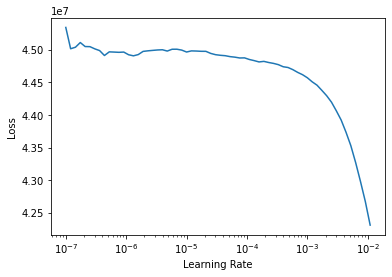

In [ ]:
lr1,lr2=learn.lr_find()

mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


epoch,train_loss,valid_loss,mse,raw_kld,mu,std,b_weighted_kld,kl_weight,mu_sd,std_sd,time
0,44165608.000000,43471812.000000,43465928.000000,15132.259766,0.004176,0.887946,75661.304688,0.000000,1.146427,1.644074,00:25
1,42346996.000000,39426704.000000,39421616.000000,32983.421875,-0.064285,0.828099,164917.093750,0.000000,1.814033,1.669171,00:24
2,37884848.000000,31601678.000000,31597010.000000,39440.066406,-0.192361,0.969266,197200.296875,0.000000,2.162786,1.237925,00:25
3,31311394.000000,25805260.000000,25799002.000000,59683.867188,-0.227901,0.936346,298419.343750,0.005403,2.626733,1.425416,00:25
4,24933354.000000,19872052.000000,19857912.000000,91569.070312,-0.136221,0.921470,457845.375000,0.021854,3.296229,1.415923,00:25
5,18691280.000000,13388205.000000,13362372.000000,92787.523438,-0.133413,0.901630,463937.687500,0.048985,3.311531,1.469861,00:24
6,13133554.000000,9235698.000000,9194264.000000,90114.593750,-0.145488,0.651241,450572.875000,0.086191,3.238479,1.501850,00:24
7,8963541.000000,6122876.000000,6070039.500000,76645.328125,-0.116771,0.366019,383226.531250,0.132641,2.847356,1.565157,00:25
8,6253648.000000,4805341.000000,4733098.000000,75472.609375,-0.112427,0.259173,377363.093750,0.187297,2.711755,1.627504,00:24
9,4618715.000000,3756382.000000,3680466.250000,60258.882812,-0.058561,0.232392,301294.375000,0.248939,2.309625,1.615863,00:25


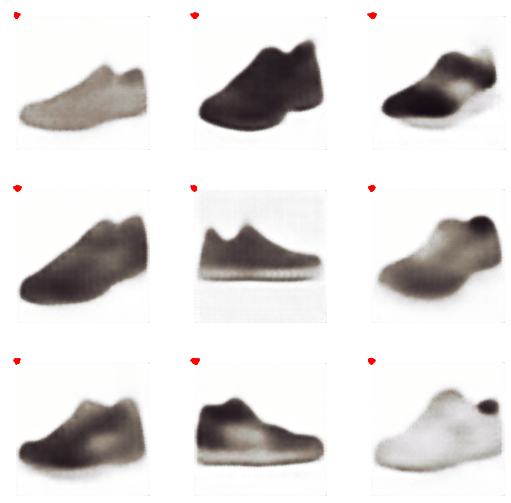

In [ ]:
#fit the backend of the VAE (n)
# the defaults are pretty good for now
freeze_epochs1 = 30
base_lr = 1e-3# gmlr #/= 2


learn.fit_one_cycle(freeze_epochs1)#, lr_max= base_lr)
#learn.fit_flat_cos(n_epoch, lr=1e-4, div_final=1e5, pct_start=0.5)

learn.show_results()


In [ ]:
# replace kl_weight scheduler... with a constant unity... (NOTE: should be robust to failure if we don't replace it)
learn.remove_cb(learn.cbs[-1])
# add new constant scheduler
f = SchedNo(1.,1.)  #is "f" still referenced by the scheduler?
learn.add_cb(ParamScheduler({'kl_weight':  SchedNo(1.,1.) }) )

# p = torch.linspace(0.,1.,100)
# plt.plot(p,[f(o) for o in p])

(1.9054606673307718e-05,
 1.3182567499825382e-06,
 1.0186431711645128e-05,
 5.011871962778969e-06)

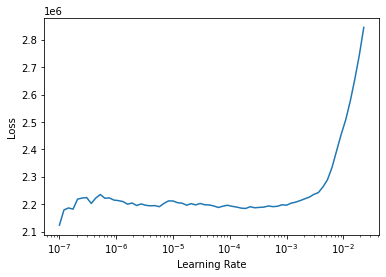

In [ ]:
lr1,lr2=learn.lr_find()

mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# #fit the full VAE  of the VAE (n)
# epochs2 = 100

# # base_lr = 5e-3# gmlr #/= 2
# # lr_mult=100
# # pct_start=0.3
# # div=5.0

# learn.fit_one_cycle(freeze_epochs2) #, lr_max= 1e-4)
# #learn.fit_flat_cos(n_epoch, lr=1e-4, div_final=1e5, pct_start=0.5)

# learn.show_results()


epoch,train_loss,valid_loss,mse,raw_kld,mu,std,b_weighted_kld,kl_weight,mu_sd,std_sd,time
0,2715989.250000,2717330.500000,2547903.750000,33741.609375,0.027272,0.312950,168708.078125,1.000000,1.617943,1.682836,00:25
1,2505618.000000,2551571.250000,2397742.500000,30630.179688,0.049057,0.278511,153150.921875,1.000000,1.424207,1.753300,00:25
2,2433591.750000,2453135.750000,2302477.500000,30020.230469,0.015065,0.277691,150101.156250,1.000000,1.397916,1.743456,00:24
3,2402024.250000,2475518.750000,2321306.000000,30726.203125,0.012454,0.275741,153631.015625,1.000000,1.420827,1.799163,00:25
4,2384089.500000,2472829.250000,2318421.500000,30778.837891,0.042509,0.274942,153894.203125,1.000000,1.418925,1.828771,00:25
5,2344707.750000,2660175.250000,2509715.750000,29974.820312,0.004963,0.272362,149874.109375,1.000000,1.379079,1.881482,00:25
6,2332165.000000,2391668.000000,2242445.750000,29736.791016,0.003861,0.284411,148683.968750,1.000000,1.394059,1.885664,00:25
7,2302658.250000,2337676.750000,2190536.750000,29317.000000,0.018548,0.274535,146585.000000,1.000000,1.355160,1.873450,00:25
8,2290907.250000,2396072.250000,2248108.250000,29467.576172,0.013035,0.281626,147337.890625,1.000000,1.373672,1.890379,00:25
9,2271225.250000,3972463853568.000000,2151385.750000,832305364992.000000,0.007129,0.281376,4161526824960.000000,1.000000,1.361863,1.951676,00:25


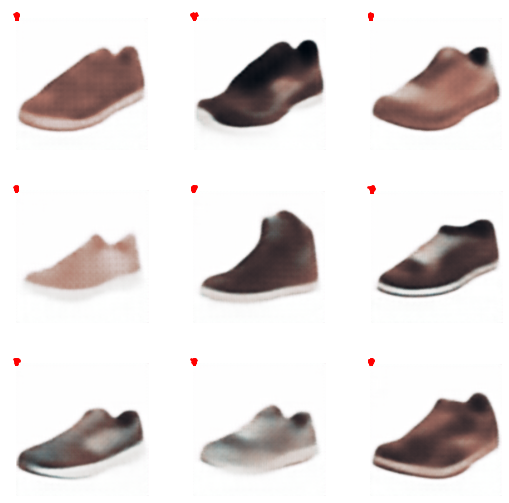

In [ ]:
#epochs = 5
base_lr = 1e-5# gmlr #/= 2
epochs = 100
learn.unfreeze()
#learn.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div)
#learn.fit_one_cycle(epochs, lr_max= 1e-3)
learn.fit_flat_cos(epochs)

learn.show_results()

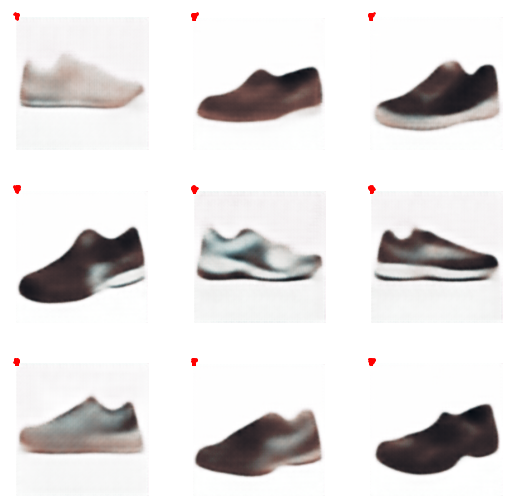

In [ ]:
learn.show_results()

In [ ]:
learn.save('VAE-beta5_mar15')

Path('models/VAE-beta5_mar15.pth')

##  other VAE flavors

> 1. MobileNet_v2 as the encoder, as a continuation of the original Sneaker Finder

> 2. linear deterministic Auto Encoder... removing the variational layer and just having it be an excercise in encoding -- a great baseline.

> 3. simple bowtie convolutional encoder / decoder
    - a. variational 
    - b. deterministic
    - Architecture Hyperparameters:
        - Latent Size (research default 256, production default 32)
        - Filter Factor Size (research default 16, production default 32)
        - Latent Linear Hidden Layer Size (research default 2048, production default 1024)
        - The encoder architecture is as follows with research defaults from above:
        - Input 3x128x128 (conv2d block [conv2d, batchnorm2d, relu])
        - 16x64x64 (conv2d block [conv2d, batchnorm2d, relu])
        - 32x32x32 (conv2d block [conv2d, batchnorm2d, relu])
        - 64x16x16 (conv2d block [conv2d, batchnorm2d, relu])
        - 128x8x8 (conv2d block [conv2d, batchnorm2d, relu])
        - Flatten to 8192
        - 2048 (linear block [linear, batchnorm1d, relu])
        - Split the 2048 dimension into mu and log variance for the parameters of the latent distribution 
        - Latent mu size 256 (linear layer only with bias)
        - Latent logvar size 256 (linear layer only with bias)
        - In the middle here you can break out the BCE and KLD loss for the final loss term and use the standard reparam trick to sample from the latent distribution.

>  - Decoder architecture an exact mirror 
        - Input 256
        - 2048 (linear block [linear, relu])
        - 8192 (linear block [linear, batchnorm1d, relu])
        - reshape (128x8x8)
        - 64x16x16 (conv2d transpose block [convtranspose2d, batchnorm2d, relu])
        - 32x32x32 (conv2d transpose block [convtranspose2d, batchnorm2d, relu])
        - 16x64x64 (conv2d transpose block [convtranspose2d, batchnorm2d, relu])
        - 3x128x128 (conv2d transpose [convtranspose2d, sigmoid]
        - For weight initialization I used a normal distribution centered at zero with 0.02 set for the stddev. Optimizer: Adam with default parameters, if I were to do it over again I'd spend more time here understanding the learning dynamics. The dataset was about ~10,000 with a 70/20/10 split, batch size 64, over 120 epochs, with a learning schedule to reduce when the loss started to plateau. No crazy image augmentation just resizing and standards flips. I used the ANN package Annoy to do the NN search for prod, normalizing the embeddings and using the cosine similarity, ANN factor was 128 for num_trees. 


In [ ]:
#  Latent Size (research default 256, production default 32)
# Filter Factor Size (research default 16, production default 32)
# Latent Linear Hidden Layer Size (research default 2048, production default 1024)
# The encoder architecture is as follows with research defaults from above:
# Input 3x128x128 (conv2d block [conv2d, batchnorm2d, relu])
# 16x64x64 (conv2d block [conv2d, batchnorm2d, relu])
# 32x32x32 (conv2d block [conv2d, batchnorm2d, relu])
# 64x16x16 (conv2d block [conv2d, batchnorm2d, relu])
# 128x8x8 (conv2d block [conv2d, batchnorm2d, relu])
# Flatten to 8192
# 2048 (linear block [linear, batchnorm1d, relu])
# Split the 2048 dimension into mu and log variance for the parameters of the latent distribution      


TODO: Ranger optimizer might really help .. test

In [ ]:
# hide
    
# check enc_dim... 
class CVAE_vanilla(Module):
    def __init__(self,latent_dim=128, hidden_dim=2048, im_size=IMG_SIZE,out_range=[-3,3],pretrained=True):
        #  drop_p=0.0 default turns off dropout, removed enc_dim=512
        
        self.im_size=im_size
        # encoder

          
        n_blocks = 5
        BASE = im_size//2**5
        
        
        nfs = [3]+[(2**i)*BASE for i in range(n_blocks)] 
        n = len(nfs)

        modules =  [ConvLayer(nfs[i],nfs[i+1],
                                ks=5,stride=2,padding=2) for i in range(n - 1)]       
        #self.in_dim = nfs[-1]*BASE*BASE# Sampling vector
        self.in_dim = nfs[-1]*(BASE)**2# Sampling vector

        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.encoder = nn.Sequential(*modules,
                                 Flatten(),
                                 LinBnDrop(self.in_dim,self.hidden_dim,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)
                                )
        

        self.bn = VAELayer(self.hidden_dim,self.latent_dim)     

        
        nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
        nfs.reverse()
        n = len(nfs)
        
        modules =  [UpsampleBlock(nfs[i]) for i in range(n - 2)]        
        self.decoder = nn.Sequential( LinBnDrop(latent_dim,self.hidden_dim,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                     LinBnDrop(hidden_dim,im_size*n_blocks*n_blocks,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                      ResizeBatch(im_size,n_blocks,n_blocks),
                                      *modules,
                                      ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None, #act_cls=nn.Sigmoid) )
                                                act_cls=partial(SigmoidRange, *out_range)))
        


    def decode(self, z):    
        z = self.decoder(z)
        return z
    
    def reparam(self, h):
        return self.bn(h)

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.reparam(h)
        return z, mu, logvar

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        x_hat = self.decode(z)
        latents = torch.stack([mu,logvar],dim=-1)
        return x_hat, latents # assume dims are [batch,latent_dim,concat_dim]
    
    

    
    

We can also use the transfer learning VAE tooling we previously built.  We just need to create the convolutional encoder and pass it in... Note that we don't have a pre-trained option, so DON'T FREEZE!

In [ ]:
#hide
# encoder
n_blocks = 5
BASE = IMG_SIZE//2**5        
nfs = [3]+[(2**i)*BASE for i in range(n_blocks)] 
n = len(nfs)

modules =  [ConvLayer(nfs[i],nfs[i+1],
                        ks=5,stride=2,padding=2) for i in range(n - 1)]       

        
conv_vae = VAEtrans(modules,enc_dim=nfs[-1],  hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=[-3,3])
    

In [ ]:
#export

def build_conv_encoder(im_size=IMG_SIZE):
    """
    make a simple convolutional ladder encoder
    """
    n_blocks = 5
    BASE = im_size//2**5        
    nfs = [3]+[(2**i)*BASE for i in range(n_blocks)] 
    n = len(nfs)

    modules =  [ConvLayer(nfs[i],nfs[i+1],
                            ks=5,stride=2,padding=2) for i in range(n - 1)]       

    return modules,nfs[-1]
    



In [ ]:

block = get_ae_DataBlock(aug=True)
#block.summary(df)


latent_dim = 128

f_init = combine_scheds([.7, .3], [SchedCos(0,1), SchedNo(1,1)])
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
               ParamScheduler({'kl_weight': f_init })]

cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': f_init })]
b_weight = 5

metrics = [MSEMetric(), 
           RawKLDMetric(), 
           MuMetric(), 
           StdMetric(),
           BWeightedKLDMetric(b_weight),
           KLWeightMetric(), 
           MuSDMetric(), 
           StdSDMetric()]


batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

# #resnet_vae = VAE_rnet(bs=batch_size,enc_dim=512)
# vae = CVAE_vanilla()


enc_arch,enc_dim = build_conv_encoder()
vae = VAEtrans(enc_arch,enc_dim=enc_dim,  hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=[-3,3])
                   
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = BVAELoss( b_weight=b_weight)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=VAEtrans_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,



In [ ]:
#this probably works best... just ramp the KLD reg way up (is 10 big?)
#. and then relax it as the filters are fine tuned...

#f = combine_scheds([.3, .5, .2], [SchedCos(0,10), SchedCos(10,1), SchedNo(1,1)])


(0.0006309573538601399,
 0.005248074419796467,
 0.0029395158868283033,
 0.0018197011668235064)

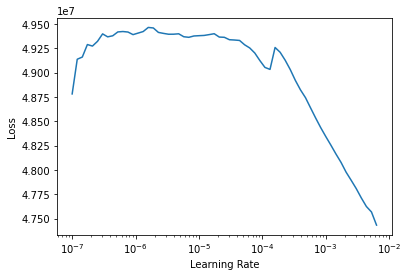

In [ ]:
lr1,lr2=learn.lr_find()

mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr

epoch,train_loss,valid_loss,mse,raw_kld,mu,std,b_weighted_kld,kl_weight,mu_sd,std_sd,time
0,39423736.000000,34076752.000000,34051156.000000,82925.789062,-0.078275,0.981833,414628.937500,0.047932,2.963904,1.775163,00:16
1,30617930.000000,24468248.000000,24419756.000000,47277.207031,-0.034070,0.964680,236386.031250,0.185387,2.315503,1.492372,00:17
2,23828536.000000,19079494.000000,19003266.000000,37321.730469,-0.080988,0.957672,186608.625000,0.385156,2.050064,1.484462,00:16
3,18261908.000000,14151012.000000,14050323.000000,32111.160156,-0.076085,0.915589,160555.796875,0.607671,1.910341,1.436595,00:17
4,13774448.000000,10839705.000000,10729973.000000,26460.480469,-0.048265,0.757056,132302.406250,0.808860,1.709619,1.435815,00:17
5,10417847.000000,8295927.500000,8169589.500000,26117.369141,-0.070088,0.512903,130586.851562,0.948876,1.579173,1.466774,00:17
6,7951051.000000,6360229.000000,6213287.000000,29010.470703,-0.051310,0.384451,145052.359375,0.999986,1.553967,1.536438,00:16
7,6179970.000000,5261290.500000,5118635.000000,28175.404297,-0.013847,0.365380,140877.015625,1.000000,1.495020,1.523723,00:16
8,4993929.500000,4321220.500000,4194367.500000,25119.941406,-0.036993,0.345962,125599.703125,1.000000,1.334049,1.492125,00:17
9,4317673.500000,4054390.500000,3936238.250000,23396.683594,-0.029938,0.336614,116983.421875,1.000000,1.236969,1.454873,00:17


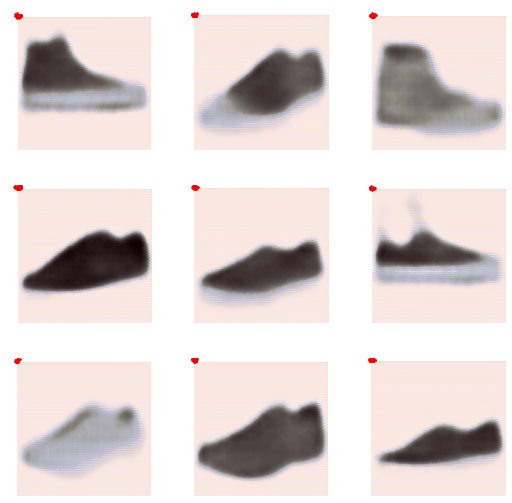

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 10
learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
#learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

In [ ]:
# # warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
# n_epoch = 40
# learn.fit_flat_cos(n_epoch, lr=1e-3, div_final=1e6, pct_start=0.3)


# learn.show_results()

In [ ]:
# replace kl_weight scheduler... 
learn.remove_cb(learn.cbs[-1])

# add new scheduler
learn.add_cb(ParamScheduler({'kl_weight': SchedNo(1.,1.) }) )


epoch,train_loss,valid_loss,mse,raw_kld,mu,std,b_weighted_kld,kl_weight,mu_sd,std_sd,time
0,3754388.000000,3635970.000000,3482278.750000,30513.556641,-0.078382,0.313671,152567.812500,1.000000,1.496704,1.650464,00:17
1,3338237.750000,3209941.500000,3055293.000000,30740.996094,-0.029309,0.307710,153704.984375,1.000000,1.498263,1.618489,00:16
2,3059510.250000,3147945.250000,2994203.000000,30551.207031,-0.044680,0.304894,152756.015625,1.000000,1.482154,1.671907,00:17
3,2884697.500000,2908697.250000,2754814.250000,30633.160156,-0.033852,0.290613,153165.796875,1.000000,1.458624,1.670878,00:16
4,2745387.250000,2759077.750000,2614467.000000,28799.445312,-0.038657,0.292501,143997.203125,1.000000,1.386847,1.652410,00:17
5,2676175.000000,2678149.000000,2528431.750000,29830.636719,-0.024223,0.290937,149153.203125,1.000000,1.427301,1.656137,00:17
6,2602977.750000,2828666.750000,2683469.000000,28900.296875,-0.033613,0.287735,144501.468750,1.000000,1.379438,1.653259,00:17
7,2555433.500000,2562259.000000,2412105.500000,29916.578125,-0.002271,0.287883,149582.906250,1.000000,1.423837,1.694603,00:17
8,2484269.500000,2630345.750000,2487601.500000,28406.632812,-0.030638,0.290723,142033.156250,1.000000,1.363870,1.686616,00:17
9,2449577.750000,2573671.750000,2433975.250000,27796.974609,-0.019067,0.287017,138984.859375,1.000000,1.326867,1.692046,00:17


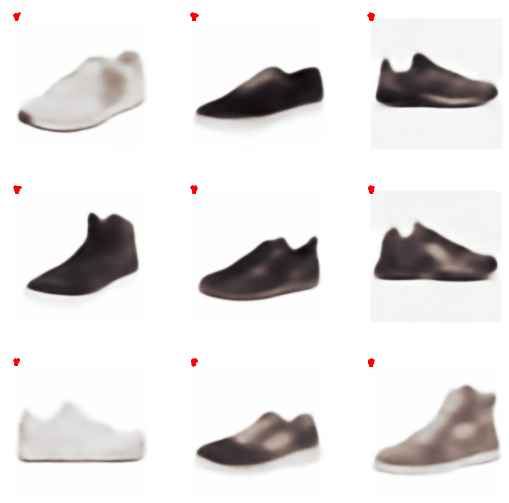

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 100
#learn.fit_flat_cos(n_epoch, lr=1e-4, div_final=1e5, pct_start=0.4)
learn.fit_flat_cos(n_epoch) 
#learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

epoch,train_loss,valid_loss,mse,raw_kld,mu,std,b_weighted_kld,kl_weight,mu_sd,std_sd,time
0,1592316.750000,1674244.000000,1516183.375000,31539.945312,0.043576,0.179046,157699.734375,1.000000,1.039528,1.062296,00:17
1,1601137.250000,1666114.250000,1507224.125000,31706.517578,0.043117,0.178589,158532.578125,1.000000,1.045419,1.068123,00:18
2,1603203.750000,1669765.500000,1512370.500000,31406.082031,0.039702,0.180111,157030.390625,1.000000,1.034803,1.071638,00:17
3,1596948.250000,1668485.875000,1510337.875000,31555.820312,0.043984,0.178987,157779.093750,1.000000,1.038007,1.071489,00:18
4,1598957.875000,1662812.125000,1504831.375000,31523.759766,0.043641,0.178274,157618.828125,1.000000,1.033294,1.068981,00:17
5,1599142.625000,1664876.500000,1507001.250000,31502.361328,0.046993,0.178036,157511.812500,1.000000,1.030606,1.070010,00:16
6,1596978.500000,1679029.750000,1520721.500000,31587.167969,0.044156,0.178661,157935.859375,1.000000,1.037087,1.076144,00:17
7,1600327.250000,1664057.625000,1505516.500000,31634.792969,0.043963,0.178798,158173.968750,1.000000,1.041733,1.072182,00:17
8,1595990.750000,1673734.750000,1515265.000000,31622.082031,0.041939,0.176912,158110.406250,1.000000,1.031623,1.071319,00:16
9,1601938.125000,1662473.000000,1504752.875000,31471.251953,0.044729,0.177256,157356.281250,1.000000,1.024658,1.070631,00:17


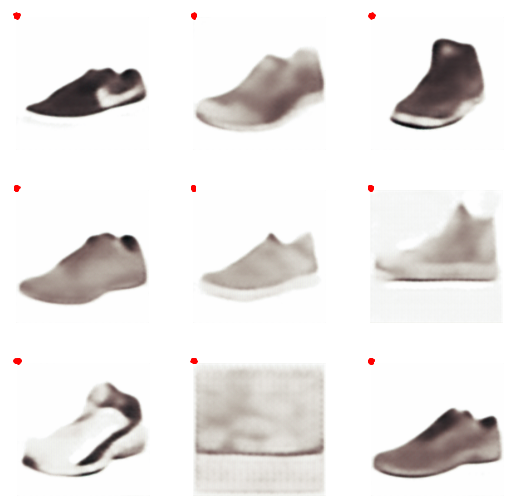

In [ ]:
# # warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
# n_epoch = 100
# learn.fit_flat_cos(n_epoch, lr=1e-4,  pct_start=0.2)
# #learn.fit_flat_cos(n_epoch) 
# #learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

# learn.show_results()

(9.120108734350651e-06,
 9.999999747378752e-06,
 9.560054240864702e-06,
 9.549926289764699e-06)

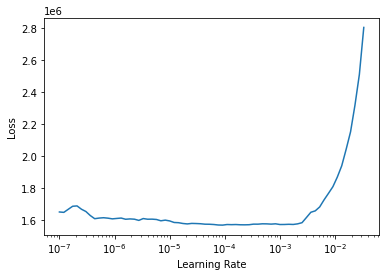

In [ ]:
lr1,lr2=learn.lr_find()

mlr = .5*(lr1+lr2)
#geometric mean
gmlr = torch.tensor([lr1,lr2]).log().mean().exp().tolist()

lr1,lr2,mlr,gmlr


In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 100
learn.fit_flat_cos(n_epoch, lr=5e-5,  pct_start=0.5)
#learn.fit_flat_cos(n_epoch) 
#learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

epoch,train_loss,valid_loss,mse,raw_kld,mu,std,b_weighted_kld,kl_weight,mu_sd,std_sd,time
0,1568804.375000,1638408.375000,1480139.375000,31580.669922,0.045500,0.173437,157903.359375,1.000000,0.998710,1.115916,00:17
1,1565757.000000,1642618.500000,1482972.625000,31855.804688,0.043893,0.172087,159279.000000,1.000000,1.007344,1.117600,00:17
2,1568502.750000,1640672.625000,1482263.375000,31608.158203,0.042245,0.172713,158040.796875,1.000000,0.996457,1.116333,00:17
3,1568016.250000,1640363.500000,1482192.375000,31562.265625,0.038011,0.173247,157811.343750,1.000000,0.996031,1.118752,00:17


KeyboardInterrupt: 

In [ ]:
learn.save('VAE-vanilla-beta5_mar14_ep310')

In [ ]:
# vae = CVAE_vanilla()

# h = vae.enc.cuda()(x)
# z,mu,logvar = vae.cuda().reparam(h)
# x_hat = vae.dec.cuda()(z)
# x_hat2,latents = vae.cuda()(x)
# h.shape,z.shape,x_hat.shape, x_hat2.shape,latents.shape

(torch.Size([64, 2048]),
 torch.Size([64, 128]),
 torch.Size([64, 3, 160, 160]),
 torch.Size([64, 3, 160, 160]),
 torch.Size([64, 128, 2]))

## ResNet AutoEncoder (deterministic)

In [ ]:
# hide

# depricate all of this...
class AEBottleneck(Module):
    def __init__(self,nfs):
        self.fc = nn.Linear(in_features,latent_features)
        n = length(nfs)
        layers = [nn.Linear(in_features=nfs[i], out_features=nfs[i+1]) for i in range(n-1)]
        self.fc = nn.Sequential(*layers)

    def forward(self,x):
        bs = x.size(0)
        x = x.view(bs, -1) # we can skip flattening the input
        z = self.fc(x)
        return z



class AE_mnet(Module):
    def __init__(self,latent_dim=128, im_size=IMG_SIZE,out_range=[-3,3],pretrained=True):
        #  drop_p=0.0 default turns off dropout
        
        
        self.im_size=im_size
        BASE = IMG_SIZE//2**5
        self.latent_dim = latent_dim
        self.hidden_dim = 2048
        # encoder
        arch,cut = xresnet18(pretrained=True),-4
        
        
        # need to make the mnet and cut here...        
        arch,cut = torchvision.models.mobilenet_v2(pretrained=True),-1
        enc_dim = arch.classifier._modules['1'].in_features
        self.in_dim = enc_dim * BASE**2  # 2**(3*3) * (im_size//32)**2 #(output of resneet) #12800

        
        self.encoder = nn.Sequential(*list(arch.children())[:cut],
                                 Flatten(),
                                 LinBnDrop(self.in_dim,self.hidden_dim,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)
                                )



        # AE (deterministic) Bottleneck
        self.bn = nn.Linear(self.hidden_dim,self.latent_dim)
        #self.bn = AEBottleneck(self.hidden_dim,self.latent_dim)     

        #decoder
        n_blocks = 5        
        nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
        nfs.reverse()
        n = len(nfs)
        
        modules =  [UpsampleBlock(nfs[i]) for i in range(n - 2)]        
        self.decoder = nn.Sequential( LinBnDrop(latent_dim,self.hidden_dim,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                     LinBnDrop(hidden_dim,im_size*n_blocks*n_blocks,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                      ResizeBatch(im_size,n_blocks,n_blocks),
                                      *modules,
                                      ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None, #act_cls=nn.Sigmoid) )
                                                act_cls=partial(SigmoidRange, *out_range)))
        


    def decode(self, z):    
        return self.decoder(z)
    
    def encode(self, x):
        h = self.encoder(x)
        return self.bn(h)
            
    def forward(self, x):
        """
        pass the "latents" out to keep the learn mechanics consistent... 
        """
        h = self.encoder(x)
        z = self.bn(h)
        x_reconst = self.decoder(z)
        latents = torch.stack([h,torch.exp(0.5 * h)] ,dim=-1)
        return x_reconst , latents
    
    
class AE_vanilla(Module):
    def __init__(self,latent_dim=128, im_size=IMG_SIZE,out_range=[-3,3],pretrained=True):
        #  drop_p=0.0 default turns off dropout
        
        
        self.im_size=im_size
        # encoder

          
        n_blocks = 5
        BASE = IMG_SIZE//2**5
        
        
        nfs = [3]+[(2**i)*BASE for i in range(n_blocks)] 
        n = len(nfs)

        modules =  [ConvLayer(nfs[i],nfs[i+1],
                                ks=5,stride=2,padding=2) for i in range(n - 1)]       
        #self.in_dim = nfs[-1]*BASE*BASE# Sampling vector
        self.in_dim = nfs[-1]*(BASE)**2# Sampling vector

        self.latent_dim = latent_dim
        self.hidden_dim = 2048
        self.encoder = nn.Sequential(*modules,
                                 Flatten(),
                                 LinBnDrop(self.in_dim,self.hidden_dim,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)
                                )
        

        self.bn = nn.Linear(self.hidden_dim,self.latent_dim)
        #self.bn = AEBottleneck(self.hidden_dim,self.latent_dim)     

        
        nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
        nfs.reverse()
        n = len(nfs)
        
        modules =  [UpsampleBlock(nfs[i]) for i in range(n - 2)]        
        self.decoder = nn.Sequential( LinBnDrop(latent_dim,im_size*n_blocks*n_blocks,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                      ResizeBatch(im_size,n_blocks,n_blocks),
                                      *modules,
                                      ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None, #act_cls=nn.Sigmoid) )
                                                act_cls=partial(SigmoidRange, *out_range)))
        


    def decode(self, z):    
        return self.decoder(z)
    
    def encode(self, x):
        h = self.encoder(x)
        return self.bn(h)
            
    def forward(self, x):
        """
        pass the "latents" out to keep the learn mechanics consistent... 
        """
        h = self.encoder(x)
        z = self.bn(h)
        x_reconst = self.decoder(z)                    
        latents = torch.stack([z,torch.clamp(z,-30,30)] ,dim=-1)


        return x_reconst , latents
    

    

In [ ]:
#export

class AEtrans(Module):
    def __init__(self,enc_arch,enc_dim=512,hidden_dim=2048, latent_dim=128, im_size=IMG_SIZE,out_range=[-3,3]):
       
        """
        inputs:  
            arch, cut,pretrained
            enc_dim
            latent_dim
            hidden_dim
            
        """
        store_attr('enc_dim, hidden_dim,latent_dim,im_size')

        # encoder
        #  arch,cut = xresnet18(pretrained=True),-4
        #  enc_arch = list(arch.children())[:cut]
        
        self.encoder = build_AE_encoder(enc_arch,enc_dim=enc_dim, hidden_dim=hidden_dim, im_size=im_size)


        # VAE Bottleneck
        #self.bn = VAELayer(self.hidden_dim,self.latent_dim)     
        self.bn = nn.Linear(self.hidden_dim,self.latent_dim)

        #decoder
        self.decoder = build_AE_decoder(hidden_dim=hidden_dim, latent_dim=latent_dim, im_size=im_size,out_range=out_range)

    
    def decode(self, z):    
        return self.decoder(z)
    
    def encode(self, x):
        h = self.encoder(x)
        return self.bn(h)
            
    def forward(self, x):
        """
        pass the "latents" out to keep the learn mechanics consistent... 
        """
        h = self.encoder(x)
        z = self.bn(h)
        x_reconst = self.decoder(z)                    
        latents = torch.stack([z,torch.clamp(z,-30,30)] ,dim=-1)


        return x_reconst , latents
    

In [ ]:
# export

# called `after_batch`
# not efficient, but keeps things consistent with VAE
class AELoss(Module):
    """
    Measures how well we have created the original image, 
    plus the KL Divergence with the unit normal distribution
    """
    def __init__(self, b_weight=1.):
        mse = MSELossFlat(reduction='sum')
        store_attr('mse,b_weight')
        
    def forward(self, preds, *target):
        """
        pred =(x_hat,KLD,kl_weight) #mu,log_var, kl_weight)
        target is x (original) 
        """
        # For now there is no latent regularization.... so we can just ignore kl_weight
        
        # this handles the annealed kl_weight and passing the mu,logvar around we added...
        if(len(preds) == 3):
            x_hat, latents, kl_weight = preds
        else: #if len(preds) == 2:  # we should never get here... unless we delete teh callback
            x_hat, latents = preds
            
            kl_weight = x_hat[0].new(1)
            kl_weight[0] = 1.0
        
        #mu,logvar = latents[:,:,0],latents[:,:,1]
        mu, logvar = latents.split(1,dim=2)

        #note: both mse and KLD are summing errors over batches, and pixels or latents 
        total = self.mse(x_hat, target[0]) 
        
        KLD = torch.zeros_like(mu) #-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        KLD = self.b_weight*KLD.sum()
        
        
        return (total + KLD*kl_weight)

    
        

In [ ]:
latent_dim = 128

f_init = combine_scheds([.7, .3], [SchedCos(0,1), SchedNo(1,1)])
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
               ParamScheduler({'kl_weight': f_init })]

b_weight = 5

metrics = [MSEMetric(), 
           RawKLDMetric(), 
           MuMetric(), 
           StdMetric(),
           BWeightedKLDMetric(b_weight),
           KLWeightMetric(), 
           MuSDMetric(), 
           StdSDMetric()]


batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)

#resnet_vae = VAE_rnet(bs=batch_size,enc_dim=512)
vae = AEtrans()
# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = AELoss( b_weight=b_weight)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=VAEtrans_split) #.to_fp16() #wd=config['wd'],opt_func=ranger,




NameError: name 'AEtrans' is not defined

epoch,train_loss,valid_loss,mse,raw_kld,mu,std,b_weighted_kld,kl_weight,mu_sd,std_sd,time
0,38131508.000000,31439656.000000,31434354.000000,571100.625000,0.090900,1.046674,2855503.500000,0.047932,3.133682,4.848952,00:17
1,27767306.000000,20374592.000000,20370324.000000,501035.000000,0.047062,1.024520,2505174.750000,0.185387,3.073306,4.695395,00:17
2,19110616.000000,12799921.000000,12797033.000000,438283.812500,0.037218,1.020009,2191419.250000,0.385156,3.007228,4.525042,00:17
3,12767441.000000,8382005.500000,8379866.000000,1932279.125000,0.015094,1.010435,9661396.000000,0.607671,3.312469,5.277761,00:17
4,8489411.000000,5715915.000000,5714263.500000,1382494.500000,0.003319,1.004369,6912472.500000,0.808860,3.200456,4.974995,00:17
5,5861403.500000,4405538.000000,4404519.500000,1801125.375000,0.016692,1.010894,9005628.000000,0.948876,3.409498,5.543014,00:16
6,4365704.000000,3588690.500000,3587742.750000,2058699.500000,-0.045515,0.980740,10293497.000000,0.999986,3.402044,5.504872,00:17
7,3520694.250000,3202153.000000,3201318.000000,11153659.000000,-0.030354,0.988686,55768312.000000,1.000000,3.702689,6.432639,00:16
8,2985803.500000,2748118.500000,2747527.750000,2921557.250000,-0.031867,0.988531,14607786.000000,1.000000,3.488097,5.755090,00:16
9,2713026.250000,2645287.500000,2644749.750000,3880829.750000,-0.029229,0.990199,19404148.000000,1.000000,3.550025,5.942442,00:16


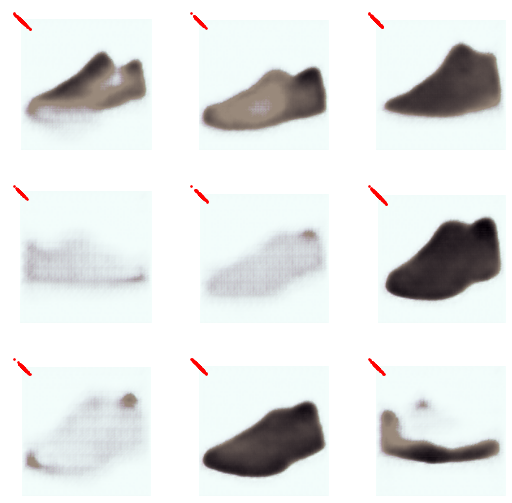

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 10
learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
#learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

## replace latent regularization term in loss_fn (KLD) with MME 

In [ ]:
# export

def gaussian_kernel(a, b):
    dim1_1, dim1_2 = a.shape[0], b.shape[0]
    depth = a.shape[1]
    a = a.view(dim1_1, 1, depth)
    b = b.view(1, dim1_2, depth)
    a_core = a.expand(dim1_1, dim1_2, depth)
    b_core = b.expand(dim1_1, dim1_2, depth)
    numerator = (a_core - b_core).pow(2).mean(2)/depth
    return torch.exp(-numerator)

def MMD(a, b):
    return gaussian_kernel(a, a).mean() + gaussian_kernel(b, b).mean() - 2*gaussian_kernel(a, b).mean()
    
    
class MMELoss(Module):
    """
    Measures how well we have created the original image, 
    plus the KL Divergence with the unit normal distribution
    """
    def __init__(self, b_weight=1.):
        mse = MSELossFlat(reduction='sum')
        store_attr('mse,b_weight')
        
    def forward(self, preds, *target):
        """
        pred =(x_hat,KLD,kl_weight) #mu,log_var, kl_weight)
        target is x (original) 
        """
        
        # this handles the annealed kl_weight and passing the mu,logvar around we added...
        if(len(preds) == 3):
            x_hat, latents, kl_weight = preds
        else: #if len(preds) == 2:  # we should never get here... unless we delete teh callback
            x_hat, latents = preds
            
            kl_weight = x_hat[0].new(1)
            kl_weight[0] = 1.0
        
        z, dummy = latents.split(1,dim=2)

        #note: both mse and KLD are summing errors over batches, and pixels or latents 
        total = self.mse(x_hat, target[0]) 
        
        bs = latents.shape[0]
        latent_dim = z.shape[1]
        true_samples = torch.randn((bs,latent_dim), requires_grad=False).cuda()
        mmd_loss = MMD(true_samples, z) * self.b_weight    
    
        return (total + mmd_loss*kl_weight)

    
        
# def compute_kernel(x, y):
#     x_size = x.shape[0]
#     y_size = y.shape[0]
#     dim = x.shape[1]

#     tiled_x = x.view(x_size,1,dim).repeat(1, y_size,1)
#     tiled_y = y.view(1,y_size,dim).repeat(x_size, 1,1)

#     return torch.exp(-torch.mean((tiled_x - tiled_y)**2,dim=2)/dim*1.0)


# def compute_mmd(x, y):
#     x_kernel = compute_kernel(x, x)
#     y_kernel = compute_kernel(y, y)
#     xy_kernel = compute_kernel(x, y)
#     return torch.mean(x_kernel) + torch.mean(y_kernel) - 2*torch.mean(xy_kernel)


# class VAERecreatedLoss(Module):
#     "Measures how well we have created the original tabular inputs, plus the KL Divergence with the unit normal distribution"
#     def __init__(self, cat_dict, dataset_size, bs, hidden_size, mmd_weight = 1000, reduction='mean'):
#         ce = CrossEntropyLossFlat(reduction='none')
#         mse = MSELossFlat(reduction='none')
#         store_attr('cat_dict,ce,mse,dataset_size,bs,hidden_size,mmd_weight,reduction')
        
#     def forward(self, preds, cat_targs, cont_targs):
#         if(len(preds) == 4):
#             cats,conts, z, kl_weight = preds
#         else:
#             cats,conts, z = preds
#             kl_weight = 1
            
#         true_samples = torch.randn((cats.shape[0],self.hidden_size))
#         true_samples = nn.Parameter(true_samples).cuda()

#         tot_ce, pos = [], 0
#         for i, (k,v) in enumerate(self.cat_dict.items()):
#             tot_ce += [self.ce(cats[:, pos:pos+v], cat_targs[:,i])]
#             pos += v

#         tot_ce = torch.stack(tot_ce, dim=1).mean(dim=1)
#         cont_loss = self.mse(conts, cont_targs).view(conts.shape).mean(dim=1)
#         recons_loss = (tot_ce + cont_loss)
        
#         mmd_loss = compute_mmd(true_samples, z).repeat(cats.shape[0])
        
#         total_loss = recons_loss + (mmd_loss * self.mmd_weight)
        
#         if self.reduction == 'mean':
#             return total_loss.mean()
#         elif self.reduction == 'sum':
#             return total_loss.sum()

#         return total_loss
        
# # test: if i call them preds instead of vals might the Metric base class reset automatically?
# class MyMetric(Metric):
#     "for simple average over batch quantities"
#     def reset(self):
#         "Clear all targs and preds"
#         self.vals = []
#     @property
#     def value(self):
#         return np.array(self.vals).mean()


    
class RawKLDMetric(MyMetric):
    def __init__(self): 
        self.vals = []
    def accumulate(self, learn):
        latents = learn.pred[1]                
        mu, logvar = latents.split(1,dim=2)
        KLD =  -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        self.vals.append(to_detach(KLD))
        

class L2Metric(MyMetric):
    def __init__(self): self.vals = []
    def accumulate(self, learn):
        x = to_detach(learn.y)
        recon_x = to_detach(learn.pred[0])
        nll = torch.mean((recon_x - x)**2)
        self.vals.append(nll)

        
    
class MMDMetric(MyMetric):
    def __init__(self, alpha=1):
        self.vals = []
        store_attr('alpha')
        
    def accumulate(self, learn):        
        latents = learn.pred[1]
        z, dummy = latents.split(1,dim=2)

        bs = latents.shape[0]
        latent_dim = z.shape[1]
        true_samples = torch.randn((bs,latent_dim), requires_grad=False).cuda()
        mmd_loss = MMD(true_samples, z) * self.alpha    
        
        self.vals.append(to_detach(mmd_loss))



In [ ]:
# #hide
# def MMEloss_function(pred, true, latent):
#     return (pred-true).pow(2).mean(), MMD(torch.randn(200, LATENT_SIZE, requires_grad = False).to(DEVICE), latent)

In [ ]:
x,y,z = dls.one_batch()

x_hat, latents = vae.cuda()(x)

  
mse = MSELossFlat(reduction='sum')
        
z, dummy = latents.split(1,dim=2)

#note: both mse and KLD are summing errors over batches, and pixels or latents 
total = mse(x_hat, y) 

bs = latents.shape[0]
latent_dim = z.shape[1]
true_samples = torch.randn((bs,latent_dim), requires_grad=False).cuda()
mmd_loss = MMD(true_samples, z) 
    

def sumMMD(a, b):
    return gaussian_kernel(a, a).sum() + gaussian_kernel(b, b).sum() - 2*gaussian_kernel(a, b).sum()


a = true_samples
b = z
aa=gaussian_kernel(a, a).sum()
bb=gaussian_kernel(b, b).sum()
ab=gaussian_kernel(a, b).sum()

mmd_loss2 = sumMMD(true_samples, z) 
    


NameError: name 'vae' is not defined

In [ ]:
mmd_loss, total,mmd_loss2, aa,bb,ab

In [ ]:
latent_dim = 128

f_init = combine_scheds([.7, .3], [SchedCos(0,1), SchedNo(1,1)])
cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               SaveModelCallback(fname=datetime.now().strftime('%Y-%m-%d %Hh%M.%S'), every_epoch=True),
               ParamScheduler({'kl_weight': f_init })]


cbs = [AnnealedLossCallback(),TerminateOnNaNCallback(),         
               ParamScheduler({'kl_weight': f_init })]
b_weight = 5
metrics = [MSEMetric(), 
           MMDMetric(), 
           MuMetric(), 
           StdMetric(),
           MuSDMetric(), 
           StdSDMetric(),
           RawKLDMetric()]


batch_size = 128
dls = block.dataloaders(df, batch_size=batch_size)



enc_arch,enc_dim = build_conv_encoder()
vae = AEtrans(enc_arch,enc_dim=enc_dim,  hidden_dim=2048,latent_dim=128, im_size=IMG_SIZE,out_range=[-3,3])


# let beta be calculated by : 3*im_size*im_size/latent_dim
loss_func = MMELoss( b_weight=b_weight)

learn = Learner(dls, vae, cbs=cbs,loss_func=loss_func, metrics=metrics,splitter=VAEtrans_split)#.to_fp16() #wd=config['wd'],opt_func=ranger,

              



epoch,train_loss,valid_loss,mse,mmd,mu,std,mu_sd,std_sd,raw_kld,time
0,32119204.000000,24644950.000000,24640422.000000,0.036459,0.113996,1.059432,2.066487,2.818878,149096.296875,00:16
1,23019228.000000,16312724.000000,16308744.000000,0.029004,0.060236,1.031052,1.996040,2.713853,87657.664062,00:17
2,15969024.000000,11421592.000000,11417917.000000,0.034234,0.055045,1.028636,2.386515,3.301291,218186.109375,00:16
3,11178027.000000,8340604.500000,8337500.500000,0.042699,0.094987,1.049299,2.713142,3.887449,1211183.625000,00:17
4,8222082.500000,6492550.000000,6489705.500000,0.046050,0.047953,1.024791,2.916309,4.303959,1012181.437500,00:16
5,6538097.000000,5803453.000000,5800829.000000,0.049094,0.038360,1.019870,3.120577,4.765782,6580361.000000,00:17
6,5605749.000000,5057373.000000,5055159.500000,0.052612,0.099254,1.051318,3.245823,5.073456,6836086.000000,00:17
7,5021273.500000,4656829.500000,4654886.500000,0.060239,0.120015,1.062501,3.454218,5.631398,25224088.000000,00:17
8,4616118.500000,4403419.000000,4401637.000000,0.058602,0.124779,1.064651,3.476875,5.696289,50579424.000000,00:17
9,4378286.500000,4273602.000000,4271838.000000,0.058933,0.094839,1.048851,3.479674,5.704420,39782388.000000,00:17


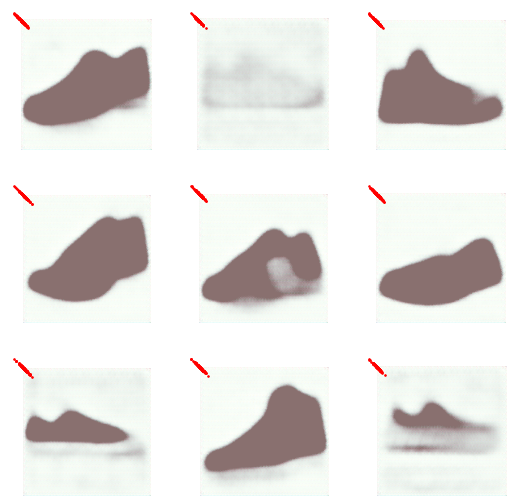

In [ ]:
# warm things up...  low-ish learning rate + anealing kldiv retularizaiton into
n_epoch = 10
learn.fit_flat_cos(n_epoch) #, lr=1e-3, div_final=1e6, pct_start=0.2)
#learn.fit_one_cycle(n_epoch) #, lr_max= base_lr)

learn.show_results()

In [ ]:
#hide

from nbdev.export import notebook2script
notebook2script()


In [ ]:
# hide
# this is depricated

class VAE_mnet(Module):
    def __init__(self,enc_dim=512, latent_dim=128, im_size=IMG_SIZE,out_range=[-3,3],pretrained=True):
        #  drop_p=0.0 default turns off dropout
        
        self.im_size=im_size
        BASE = IMG_SIZE//2**5
        self.latent_dim = latent_dim
        self.hidden_dim = 2048
        # encoder
        arch,cut = xresnet18(pretrained=True),-4
        
        
        # need to make the mnet and cut here...        
        arch,cut = torchvision.models.mobilenet_v2(pretrained=True),-1
        enc_dim = arch.classifier._modules['1'].in_features
        self.in_dim = enc_dim * BASE**2  # 2**(3*3) * (im_size//32)**2 #(output of resneet) #12800

        
        self.encoder = nn.Sequential(*list(arch.children())[:cut],
                                 Flatten(),
                                 LinBnDrop(self.in_dim,self.hidden_dim,bn=True,p=0.0,act=nn.ReLU(),lin_first=True)
                                )



        # VAE Bottleneck
        self.bn = VAELayer(self.hidden_dim,self.latent_dim)     

        #decoder
        n_blocks = 5        
        nfs = [3] + [2**i*n_blocks for i in range(n_blocks+1)] 
        nfs.reverse()
        n = len(nfs)
        
        modules =  [UpsampleBlock(nfs[i]) for i in range(n - 2)]        
        self.decoder = nn.Sequential( LinBnDrop(latent_dim,self.hidden_dim,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                     LinBnDrop(hidden_dim,im_size*n_blocks*n_blocks,
                                                bn=True,# batch normalizaiton shouldn't be a problem here
                                                p=0.0,act=nn.ReLU(),lin_first=True),
                                      ResizeBatch(im_size,n_blocks,n_blocks),
                                      *modules,
                                      ConvLayer(nfs[-2],nfs[-1],
                                                ks=1,padding=0, norm_type=None, #act_cls=nn.Sigmoid) )
                                                act_cls=partial(SigmoidRange, *out_range)))
        


    def decode(self, z):    
        z = self.decoder(z)
        return z
    
    def reparam(self, h):
        return self.bn(h)

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.reparam(h)
        return z, mu, logvar

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        x_hat = self.decode(z)
        latents = torch.stack([mu,logvar],dim=-1)
        return x_hat, latents # assume dims are [batch,latent_dim,concat_dim]
    
    
# we should be able to use the same splitter as the _rnet since we made the overall architecture equivalent

In [ ]:
## ARCHITECUTE
def create_encoder(nfs,ks,conv=nn.Conv2d,bn=nn.BatchNorm2d,act_fn = nn.ReLU):
    """
    constructor for generic convolutional encoder 
    """
    n = len(nfs)
    conv_layers = [nn.Sequential(ConvBnRelu(nfs[i],nfs[i+1],kernel_size=ks[i],
                                            conv = conv,bn=bn,act_fn=act_fn, padding = ks[i] //2 ),
                                 Downsample(channels=nfs[i+1],filt_size=3,stride=2))
                                   for i in range(n-1)]        
    convs = nn.Sequential(*conv_layers)
    return convs

def create_encoder_denseblock(n_dense,c_start):
    """
    constructor for resnet with dense blocks  (?) 

    n_dense": 3,
    "c_start": 4
    """
    first_layer = nn.Sequential(ConvBnRelu(3,c_start,kernel_size=3,padding = 1),
                                ResBlock(c_start),
                                Downsample(channels=4,filt_size=3,stride=2))
    
    layers = [first_layer] + [
        nn.Sequential(
            DenseBlock(c_start * (2**c)),
            Downsample(channels=c_start * (2**(c+1)),filt_size=3,stride=2)) for c in range(n_dense)
    ]
    
    model = nn.Sequential(*layers)
    
    return model

def create_decoder(nfs, ks, size, conv=nn.Conv2d, bn=nn.BatchNorm2d, act_fn=nn.ReLU):
    """
    CURR VALUES:
    "nfs":[66,3*32,3*16,3*8,3*4,3*2,3,1,3],
    "ks": [ 3, 1, 3,1,3,1,3,1],   
    "size": IMG_SIZE 
    """
    n = len(nfs)
    
    # We add two channels to the first layer to include x and y channels
    first_layer = ConvBnRelu(nfs[0], #input size 
                             nfs[1], # output size
                             conv = PointwiseConv,
                             bn=bn,
                             act_fn=act_fn)

    conv_layers = [first_layer] + [ConvBnRelu(nfs[i],nfs[i+1],kernel_size=ks[i-1],
                                              padding = ks[i-1] // 2,conv = conv,bn=bn,act_fn=act_fn)
                                   for i in range(1,n - 1)]        
    dec_convs = nn.Sequential(*conv_layers)
    
    dec = nn.Sequential(SpatialDecoder2D(size),dec_convs)
    #SigmoidRange(*y_range)
    return dec

def decoder_simple(y_range=[-3,3], n_out=3):
    return nn.Sequential(#UpsampleBlock(64),
                         UpsampleBlock(32),
                         nn.Conv2d(16, n_out, 1),
                         SigmoidRange(*y_range)
                        )